In [38]:
"""
prediksi_vs_simulasi_plot.py
Membuat scatter plot perbandingan hasil DNN (prediksi) vs hasil simulasi antena radar.
Gunakan setelah model surrogate (DNN) selesai dilatih.

Pastikan:
- Model: model_1.h5 & model_2.h5
- Dataset: dataset_patch_antenna_FR4_200rows.csv & dataset_patch_antenna_rogers_200rows.csv
"""


'\nprediksi_vs_simulasi_plot.py\nMembuat scatter plot perbandingan hasil DNN (prediksi) vs hasil simulasi antena radar.\nGunakan setelah model surrogate (DNN) selesai dilatih.\n\nPastikan:\n- Model: model_1.h5 & model_2.h5\n- Dataset: dataset_patch_antenna_FR4_200rows.csv & dataset_patch_antenna_rogers_200rows.csv\n'

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model

# -----------------------------
# 1. Pengaturan dasar
# -----------------------------
#DATASET_PATH = "data uji1_antena_radar.csv"
#DATASET_PATH = "data uji2_antena_radar.csv"
DATASET_PATH = "test_dataset_rectangular_circular_10GHz.csv"

#MODEL_PATH   = "model_baru.h5"
MODEL_PATH   = "model_baru_10ghz.h5"

#SAVE_DIR     = "data uji1_model baru"
#SAVE_DIR     = "data uji2_model baru"
#SAVE_DIR     = "data uji1_model baru 10ghz"
#SAVE_DIR     = "data uji2_model baru 10ghz"
#SAVE_DIR     = "data test_model baru"
SAVE_DIR     = "data test_model baru 10ghz"

os.makedirs(SAVE_DIR, exist_ok=True)

# INPUT_COLS  = ['Epsilon_r','Freq_Resonansi_GHz','Bandwidth_MHz','S11_dB','VSWR','Gain_dBi','Efisiensi_persen']
# TARGET_COLS = ['Panjang_Patch_mm','Lebar_Patch_mm','Tebal_Substrat_mm']

INPUT_COLS  = ['epsilon_r','freq_GHz','Bandwidth_MHz','S11_dB','VSWR','Gain_dBi','Efficiency_%']
TARGET_COLS = ['length_mm','width_mm','substrate_thickness_mm']


In [40]:

# -----------------------------
# 2. Load dataset dan model
# -----------------------------
print("Memuat dataset dan model...")
df = pd.read_csv(DATASET_PATH)

# Memuat model dengan compile=False untuk menghindari masalah deserialisasi metrics
try:
    model = load_model(MODEL_PATH, compile=False)
    # Compile ulang dengan metrics yang benar (menggunakan objek langsung)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    print("Model berhasil dimuat dan dikompilasi ulang.")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    print("Mencoba memuat dengan custom_objects...")
    # Alternatif: gunakan custom_objects
    custom_objects = {
        'mse': tf.keras.losses.MeanSquaredError(),
        'mae': tf.keras.metrics.MeanAbsoluteError()
    }
    model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Pastikan tipe data float
df[INPUT_COLS]  = df[INPUT_COLS].astype(float)
df[TARGET_COLS] = df[TARGET_COLS].astype(float)

# -----------------------------
# 3. Normalisasi & prediksi
# -----------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[INPUT_COLS].values
y_true = df[TARGET_COLS].values

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_true)

y_pred_scaled = model.predict(X_scaled, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# -----------------------------
# 4. Hitung metrik akurasi
# -----------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics_report(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} → MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

print("\n=== Evaluasi Model Surrogate ===")
for i, col in enumerate(TARGET_COLS):
    metrics_report(y_true[:,i], y_pred[:,i], col)


Memuat dataset dan model...
Model berhasil dimuat dan dikompilasi ulang.

=== Evaluasi Model Surrogate ===
length_mm → MAE=6.7146, RMSE=7.6487, R²=-0.0116
width_mm → MAE=6.7133, RMSE=7.7848, R²=-0.0841
substrate_thickness_mm → MAE=0.3730, RMSE=0.4343, R²=-0.0417


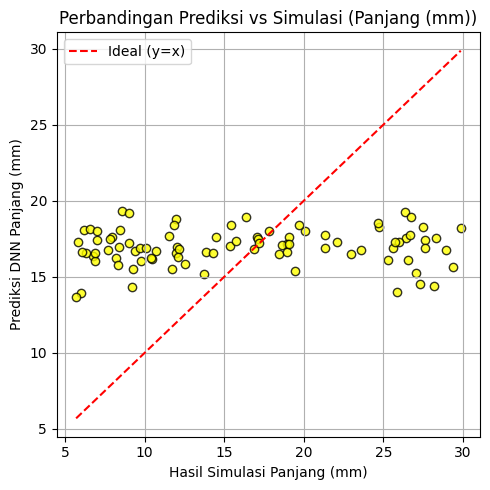

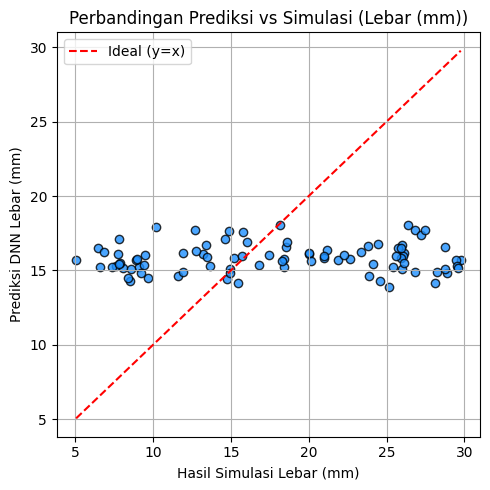

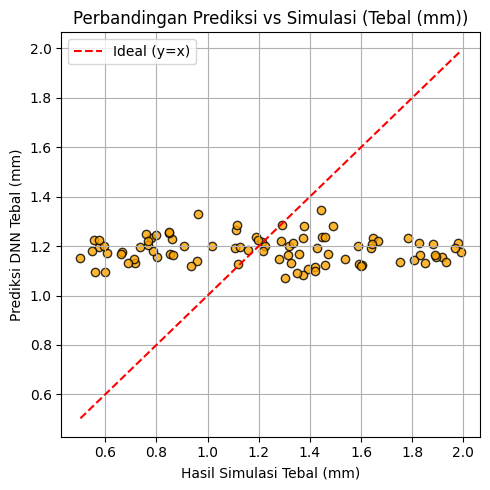

In [41]:

# -----------------------------
# 5. Plot hasil aktual vs prediksi
# -----------------------------
def scatter_plot(y_true, y_pred, label, color, save_name):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.8, color=color, edgecolor='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal (y=x)')
    plt.title(f"Perbandingan Prediksi vs Simulasi ({label})")
    plt.xlabel(f"Hasil Simulasi {label}")
    plt.ylabel(f"Prediksi DNN {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, save_name), dpi=300)
    plt.show()


scatter_plot(y_true[:,0], y_pred[:,0], "Panjang (mm)", "yellow", "pred_vs_sim_panjang_mod_data_uji.png")
scatter_plot(y_true[:,1], y_pred[:,1], "Lebar (mm)", "dodgerblue", "pred_vs_sim_lebar_mod_datauji.png")
scatter_plot(y_true[:,2], y_pred[:,2], "Tebal (mm)", "orange", "pred_vs_sim_tebal_mod_datauji.png")


In [42]:

# -----------------------------
# 6. Simpan hasil ke CSV
# -----------------------------
out_df = pd.DataFrame({
    'Panjang_sim': y_true[:,0], 'Panjang_pred': y_pred[:,0],
    'Lebar_sim': y_true[:,1], 'Lebar_pred': y_pred[:,1],
    'Tebal_sim': y_true[:,2], 'Tebal_pred': y_pred[:,2]
})

out_df.to_csv(os.path.join(SAVE_DIR, "hasil_perbandingan_prediksi_simulasi_mod_data_uji.csv"), index=False)
print("\nFile hasil dan grafik tersimpan di folder:", SAVE_DIR)



File hasil dan grafik tersimpan di folder: data test_model baru 10ghz
